# Meta label metric

Testing different base model evaluation performance metric (used as meta label)

- precision
- recall
- auc
- kappa
- f1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, evaluator, Model
from utils import plot_results

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [2]:
LABEL_COL = "precision"
PREDICTION_COL = "predicted"
STEP = 30  # Step for next meta learning iteration
TRAIN_WINDOW_SIZE = 97  # Target is unknown

META_MODEL = ltb.LGBMRegressor
META_MODEL_HYPERPARAMS = {"num_leaves": 21, "max_depth": 5}
meta_model = Model(verbose=True, basis_model=META_MODEL, hyperparameters=META_MODEL_HYPERPARAMS)

## Read data

In [3]:
df = pd.read_csv("metabases/random_forest.csv")
df.head()

,psi_nswprice,psi_nswdemand,psi_vicprice,psi_vicdemand,psi_transfer,psi_weekday,psi_predict_proba,nswprice_mean,nswprice_std,nswprice_min,...,recall,f1-score,auc,kappa,last_precision,last_recall,last_f1-score,last_auc,last_kappa,predicted
344,2.617905,3.292880,0,0,0,4.780299,2.099704,0.052036,0.009168,0.027891,...,1.000000,0.756410,0.536585,0.085219,0.700000,1.000000,0.823529,0.635135,0.318182,0.622370
345,2.474172,4.176450,0,0,0,4.346127,1.266766,0.052538,0.010003,0.027891,...,1.000000,0.637681,0.553571,0.095514,0.637363,1.000000,0.778523,0.607143,0.240331,0.617878
346,2.184946,2.696057,0,0,0,3.238288,0.533208,0.054769,0.011794,0.027891,...,1.000000,0.630769,0.593220,0.158190,0.797872,1.000000,0.887574,0.620000,0.321429,0.711325
355,0.261487,0.105817,0,0,0,4.887066,0.220062,0.074766,0.023466,0.037258,...,0.750000,0.857143,0.875000,0.757282,0.926829,1.000000,0.962025,0.875000,0.820144,0.770962
356,0.276270,0.164454,0,0,0,4.417075,0.323463,0.073767,0.023579,0.037258,...,0.836735,0.911111,0.918367,0.839422,0.927536,0.969697,0.948148,0.911319,0.840619,0.736370


In [4]:
y_true = df["precision"]
y_pred = df["predicted"]
y_baseline = df["last_precision"]

Text(0.5, 1.0, 'Baseline')

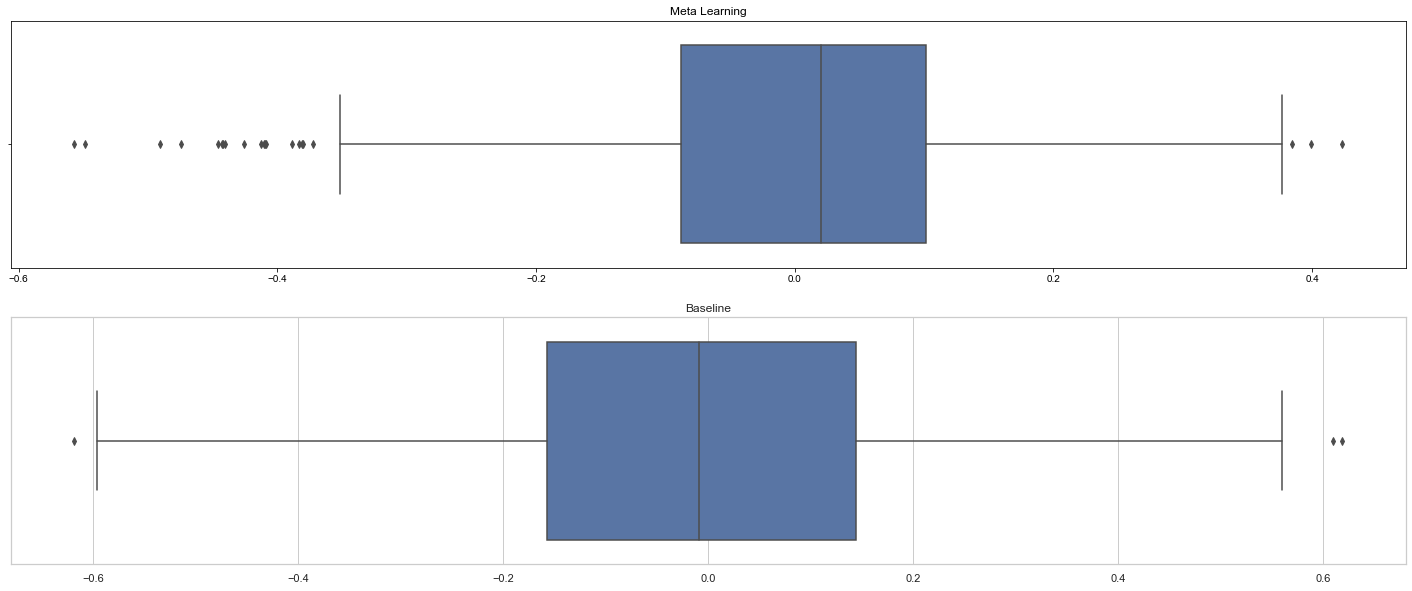

In [5]:
fig = plt.figure(figsize=(25, 10))

plt.subplot(2, 1, 1)
evaluator.box_plot(y_true, y_pred)
plt.title("Meta Learning")

plt.subplot(2, 1, 2)
evaluator.box_plot(y_true, y_baseline)
plt.title("Baseline")

In [12]:
cumulative_gain

344     -0.008219
345     -0.014436
346     -0.065313
355     -0.018208
356      0.046041
          ...    
1252   -22.960615
1253   -23.199494
1254   -23.476382
1255   -23.689134
1256   -23.729381
Length: 905, dtype: float64

Text(0.5, 1.0, 'Cumulative gain')

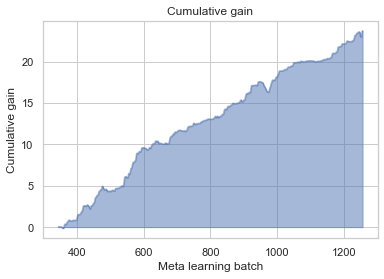

In [16]:
# evaluator.cumulative_gain(y_true, y_pred, y_baseline)
metric_name = "mse"
import numpy as np

metalearning_error = np.square(y_true - y_pred)
baseline_error = np.square(y_true - y_baseline)
mtl_gain = baseline_error - metalearning_error
cumulative_gain = mtl_gain.cumsum()
cumulative_gain.plot.area(stacked=False)

print("Cumulative gain definition: squared_error(baseline) - squared_error(metalearning)")
plt.xlabel("Meta learning batch")
plt.ylabel("Cumulative gain")
plt.title("Cumulative gain")

## Fase offline

In [6]:
base_model = Model(basis_model=RandomForestClassifier, hyperparameters={"max_depth": 6, "warm_start": True, "min_samples_split": 0.05})
meta_model = Model(basis_model=ltb.LGBMRegressor, hyperparameters={"num_leaves": 21, "max_depth": 5})

learner = MetaLearner(
    base_model=base_model,
    meta_model=meta_model,
    base_model_class_column=CLASS_COL,
    eta=ETA,
    step=STEP,
    known_target_window_size=KNOWN_TARGET_WINDOW_SIZE,
    learning_window_size=LEARNING_WINDOW_SIZE,
    )

learner.fit(offline_df)

# Experiments

In [7]:
validation_base = learner._get_offline_metabase(validation_df)
results = []

In [8]:
# BASELINE

for metric in evaluator.clf_metrics:
    y_true = learner.meta_base[metric]
    y_pred = [np.mean(y_true)] * len(y_true)
    r2 = evaluator.evaluate(y_true, y_pred, 'r2')
    mse = evaluator.evaluate(y_true, y_pred, 'mse')
    std = evaluator.evaluate(y_true, y_pred, 'std')
    results.append({'r2': r2, 'mse': mse, 'std': std, 'type': 'baseline', 'metric': metric})

pd.DataFrame(results)

,r2,mse,std,type,metric
0,0.0,0.022041,0.148463,baseline,precision
1,0.0,0.021729,0.147408,baseline,recall
2,0.0,0.009381,0.096855,baseline,f1-score
3,0.0,0.010062,0.100310,baseline,auc
4,0.0,0.042223,0.205483,baseline,kappa


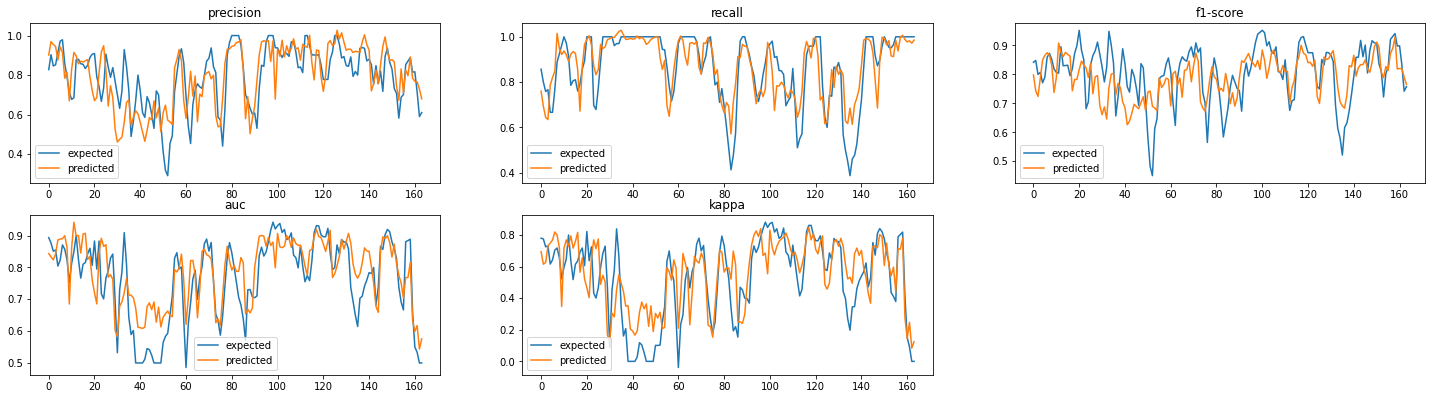

In [10]:
models = {}
fig = plt.figure(figsize=(25, 10))

for idx, metric in enumerate(evaluator.clf_metrics):
    update_params={'meta_label_metric': metric}
    y_true, y_pred = offline_train(update_params, learner, validation_base)
    result = plot_results(y_true, y_pred, title=metric, idx=idx)
    models[metric] = learner.meta_model.model
    
    result = {**result, **{'type': 'meta learning', 'metric': metric}}
    results.append(result)

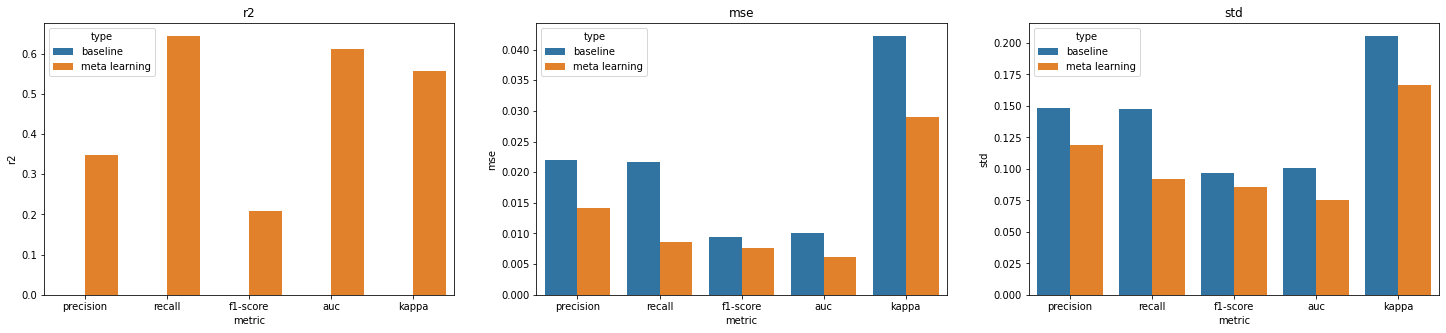

In [11]:
results_metrics = pd.DataFrame(results)
fig = plt.figure(figsize=(25, 5))

for idx, col in enumerate(['r2', 'mse', 'std']):
    plt.subplot(1, 3, idx + 1)
    sns.barplot(x="metric", hue="type", y=col, data=results_metrics)
    plt.title(col)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

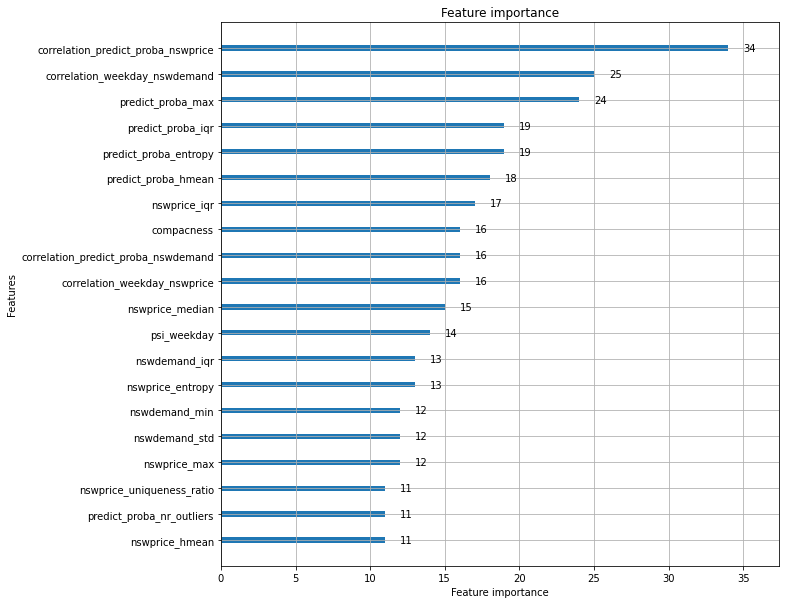

In [12]:
metric = 'precision'
ltb.plot_importance(models[metric], figsize=(10, 10), max_num_features=20)